In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import json
import scipy

In [3]:
def scatter_x_vs_y(x, y, xmax, ymax, xlabel, ylabel, title=" "):
    fig = plt.figure(figsize=(6, 6))
    fig.patch.set_facecolor("white")
    plt.axis((0.0, xmax, 0.0, ymax))
    plt.plot([0, xmax], [0, ymax], color="red")
    plt.scatter(x, y, s=0.01)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Load config and scores df

In [4]:
config_file = "cori_config.json"
with open(config_file, "r") as f:
    p = json.load(f)

In [5]:
df_scores_ordered = pd.read_pickle("SCORES.pkl.gz")

In [6]:
max_tm_scores = np.maximum(df_scores_ordered["TM1"], df_scores_ordered["TM2"])
df_scores_ordered["distance"] = 1 - max_tm_scores

In [7]:
df_scores_ordered["weight"] = (100 / df_scores_ordered["pidentity"]) ** 3

In [8]:
# Find the maximum TMscore for each row, then get the corresponding TM %id. 
df_dummy = df_scores_ordered[['TM1', 'TM2']].rename(columns={"TM1":0, "TM2":1})
df_maxcol = df_dummy.idxmax(axis='columns').values
vals = df_scores_ordered[['pID1', 'pID2']].values
max_TM_pid = vals[np.arange(len(vals)), df_maxcol] 
df_scores_ordered['max_TM_pid'] = 100 * max_TM_pid

In [9]:
# Calculate the TMalign IDali to blast %id ratio
df_scores_ordered['TMoverBlastPID'] = 100 * df_scores_ordered['IDali']/df_scores_ordered['pidentity']

In [10]:
df_scores_ordered['RMSD'].describe()

count    3.218568e+06
mean     2.106039e+00
std      1.194385e+00
min      0.000000e+00
25%      1.270000e+00
50%      1.900000e+00
75%      2.790000e+00
max      9.460000e+00
Name: RMSD, dtype: float64

In [11]:
df_scores_ordered.sample(5).head()[['TM1', 'TM2', 'pID1', 'pID2', 'pidentity', 'weight', 'distance']]

TM1     TM2   pID1   pID2  pidentity    weight  distance
1706104  0.9834  0.9834  0.795  0.795     79.817  1.966590    0.0166
1330543  0.9272  0.9150  0.690  0.680     70.925  2.802864    0.0728
104242   0.6811  0.6765  0.443  0.439     72.523  2.621638    0.3189
1341577  0.8837  0.8405  0.850  0.804     82.174  1.802174    0.1163
3177864  0.6663  0.6713  0.587  0.592     92.925  1.246242    0.3287

## Filter out sequences longer than cutoff. Also keep only ordered pairs.

In [12]:
MAX_LEN = p['MAX_SEQ_LEN']
TMSCORE_CUTOFF = 0.0 #p['TMSCORE_CUTOFF']
df_scores = df_scores_ordered[
    (df_scores_ordered.qlen <= MAX_LEN) & 
    (df_scores_ordered.tlen <= MAX_LEN) & 
    (df_scores_ordered.TM1 > TMSCORE_CUTOFF) & 
    (df_scores_ordered.TM2 > TMSCORE_CUTOFF)]

In [13]:
print("# pairs w/ 0 RMSD: ",len(df_scores[df_scores.RMSD == 0]))
print("Max RMSD for the length-filtered set", df_scores.RMSD.max())

# pairs w/ 0 RMSD:  74
Max RMSD for the length-filtered set 8.41


# Stats

In [14]:
all_ids = np.append(df_scores.qid.unique(), df_scores.tid.unique())
all_ids = np.unique(all_ids)

df_train = df_scores[df_scores.train_or_holdout == 0]
df_singleHO = df_scores[(df_scores.train_or_holdout == 1) | (df_scores.train_or_holdout == 2)]
df_doubleHO = df_scores[df_scores.train_or_holdout == 3]

print("{:,} pairs in complete df_scores (training+holdout, no filtering)".format(len(df_scores_ordered)))
print("{:,} pairs after length filtering (training+holdout; cutoff = {} residues)".format(len(df_scores), MAX_LEN))
print("{:,} PDB IDs after length filtering (training+holdout)".format(len(all_ids)))
print("{:,} pairs in training set".format(len(df_train)))
print("{:,} pairs in single holdout".format(len(df_singleHO)))
print("{:,} pairs in double holdout".format(len(df_doubleHO)))

3,218,568 pairs in complete df_scores (training+holdout, no filtering)
3,017,730 pairs after length filtering (training+holdout; cutoff = 400 residues)
64,617 PDB IDs after length filtering (training+holdout)
2,288,424 pairs in training set
663,592 pairs in single holdout
65,714 pairs in double holdout


# Visualization

## Plot distributions

In [15]:
def plot_hist(df_column, title, ylabel, xlabel, savefile, bins=100):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.patch.set_facecolor('white')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    df_column.hist(bins=bins, ax=ax)
    plt.savefig(savefile)
    plt.show()

In [16]:
folder = "save/plots/"
prefix = "COMPLETE_DATA_SET_"

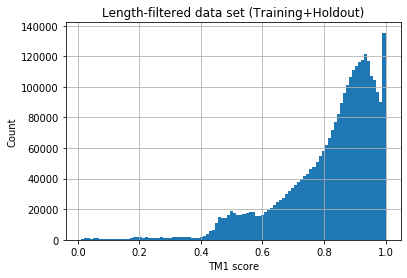

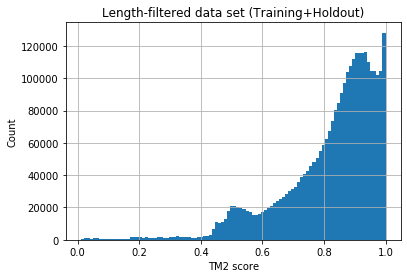

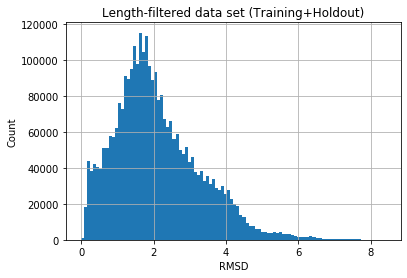

In [17]:
plot_hist(
    df_scores.TM1, 
    'Length-filtered data set (Training+Holdout)',
    'Count',
    'TM1 score',
    folder + prefix + "TM1-score.png"
)

plot_hist(
    df_scores.TM2, 
    'Length-filtered data set (Training+Holdout)',
    'Count',
    'TM2 score',
    folder + prefix + "TM1-score.png"
)

plot_hist(
    df_scores.RMSD, 
    'Length-filtered data set (Training+Holdout)',
    'Count',
    'RMSD',
    folder + prefix + "RMSD.png"
)

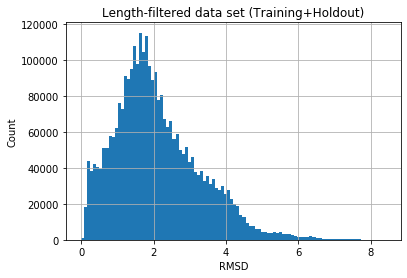

In [18]:
plot_hist(
    df_scores.RMSD, 
    'Length-filtered data set (Training+Holdout)',
    'Count',
    'RMSD',
    folder + prefix + "RMSD.png"
)

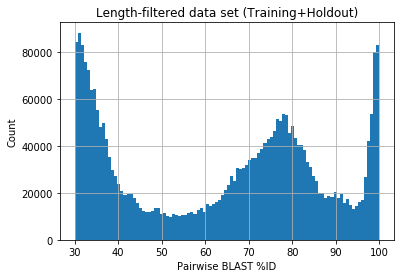

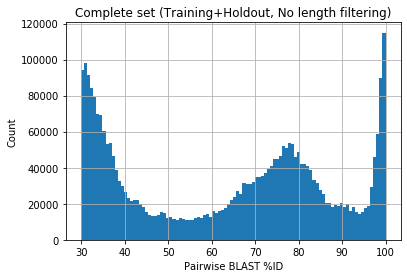

In [19]:
plot_hist(
    df_scores.pidentity, 
    'Length-filtered data set (Training+Holdout)',
    'Count',
    'Pairwise BLAST %ID',
    folder + prefix + "blast_pID.png"
)

plot_hist(
    df_scores_ordered.pidentity, 
    'Complete set (Training+Holdout, No length filtering)',
    'Count',
    'Pairwise BLAST %ID',
    folder + prefix + "blast_pID.png"
)

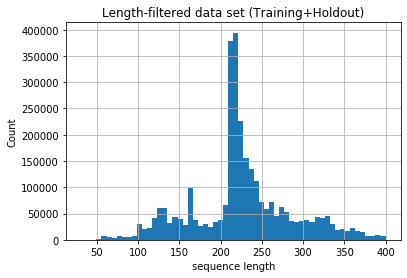

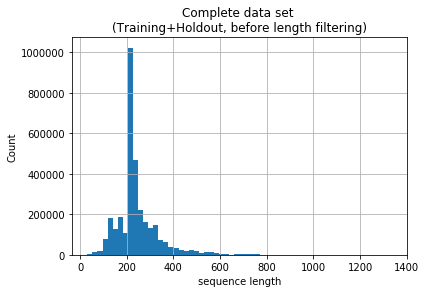

In [20]:
plot_hist(
    df_scores.qlen, 
    'Length-filtered data set (Training+Holdout)',
    'Count',
    'sequence length',
    folder + prefix + "sequence_length.png",
    bins=60
)

plot_hist(
    df_scores_ordered.qlen, 
    'Complete data set \n(Training+Holdout, before length filtering)',
    'Count',
    'sequence length',
    folder + prefix + "sequence_length.png",
    bins=60
)

## Plot joint distributions: %sequence id vs structural similarity score

In [21]:
#df_sample = df_scores.sample(n=1000000)
df_sample = df_scores
x = df_sample.pidentity.values
y = 1 - df_sample['distance']

double_HO_set = df_sample[df_sample.train_or_holdout==3]
x_holdout = double_HO_set.pidentity.values
y_holdout = double_HO_set.TM1.values

<Figure size 216x216 with 0 Axes>

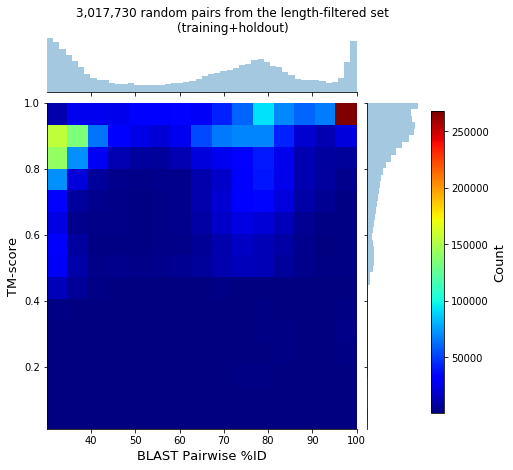

In [22]:
title = "{:,} random pairs from the length-filtered set\n(training+holdout)".format(len(df_sample))
xlabel = "BLAST Pairwise %ID"
ylabel = "TM-score"
savefile = folder + prefix + "tmscore_vs_pidentity.png"

fig = plt.figure(figsize=(3,3))
fig.patch.set_facecolor('white')


ax1 = sns.jointplot(x=x, y=y)
ax1.ax_joint.cla()
plt.sca(ax1.ax_joint)

plt.title(title, y=1.2, x=0.6)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel,fontsize=13)

h = plt.hist2d(x, y, bins=(15, 15), cmap=cm.jet);
cbar_ax = ax1.fig.add_axes([1, 0.1, .03, .7])
cb = plt.colorbar(cax=cbar_ax)
cb.set_label('Count',fontsize=13)
plt.savefig(savefile)

<Figure size 216x216 with 0 Axes>

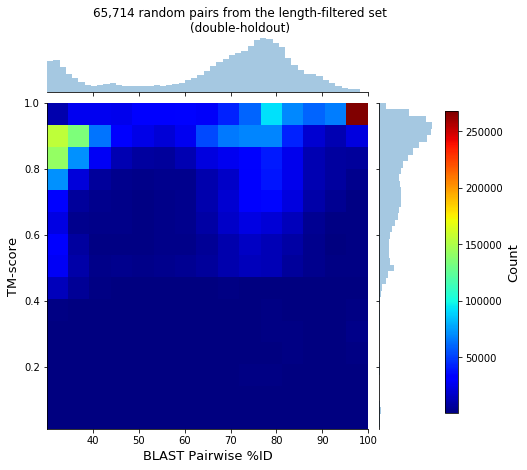

In [23]:
title = "{:,} random pairs from the length-filtered set\n(double-holdout)".format(len(x_holdout))

fig = plt.figure(figsize=(3,3))
fig.patch.set_facecolor('white')
savefile = folder + prefix + "tmscore_vs_pidentity_2.png"

ax1 = sns.jointplot(x=x_holdout, y=y_holdout)
ax1.ax_joint.cla()
plt.sca(ax1.ax_joint)

plt.title(title, y=1.2, x=0.6)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel,fontsize=13)

#h = plt.hist2d(x, y, bins=(15, 15), cmap=cm.jet, range=[(30,95),(0,.95)]);
h = plt.hist2d(x, y, bins=(15, 15), cmap=cm.jet);
cbar_ax = ax1.fig.add_axes([1, 0.1, .03, .7])
cb = plt.colorbar(cax=cbar_ax)
cb.set_label('Count',fontsize=13)
plt.savefig(savefile)

## Max %ID between a seq in the holdout set and and on in the training set

Why is this important? Because I want to find out if any of my holdout seq sequences are very similar to the trianing ones. That would defeat the purpose of a holdout set.

In [24]:
# Select training_or_holdout == 1, which is the set of pairs with the first sequence is from the holdout PDBids.
double_HO_set = df_scores[df_scores.train_or_holdout==3]

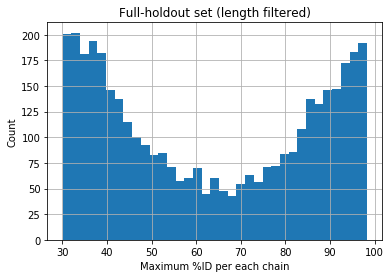

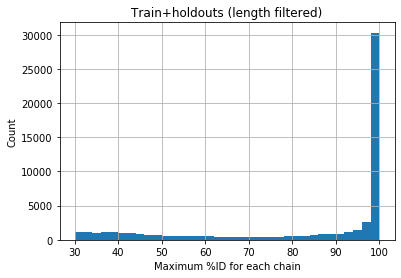

In [25]:
df_doubleHO_max_pid = double_HO_set[['qid', 'pidentity']].groupby('qid').max()
df_scores_max_pid   = df_scores[['qid', 'pidentity']].groupby('qid').max()

plot_hist(
    df_doubleHO_max_pid.pidentity,
    'Full-holdout set (length filtered)',
    'Count',
    'Maximum %ID per each chain',
    folder + prefix + "doubleHO_max_pid_to_training_set.png",
    bins=35
)


plot_hist(
    df_scores_max_pid.pidentity,
    'Train+holdouts (length filtered)',
    'Count',
    'Maximum %ID for each chain',
    folder + prefix + "doubleHO_max_pid_to_training_set.png",
    bins=35
)

In [26]:
"{:.2f}".format(12.11123)

'12.11'

# %sequence identity vs tmscore

In [27]:
df_scores.head(2)

pdbid1  model1 chain1 pdbid2  model2 chain2     TM1     TM2  RMSD   pID1  \
0   101m       1      A   102m       1      A  0.9989  0.9989  0.15  0.987   
1   101m       1      A   104m       1      A  0.9826  0.9890  0.50  0.981   

   ...  qlen  tlen  perc_q_cov_per_hsp         evalue  bitscore  \
0  ...   154   154                 100  7.080000e-108     304.0   
1  ...   154   153                  99  3.630000e-107     302.0   

  train_or_holdout distance    weight  max_TM_pid TMoverBlastPID  
0                0   0.0011  1.040005        98.7       0.999990  
1                0   0.0110  1.040258        98.7       1.000071  

[2 rows x 34 columns]

In [28]:
df_scores.columns

Index(['pdbid1', 'model1', 'chain1', 'pdbid2', 'model2', 'chain2', 'TM1',
       'TM2', 'RMSD', 'pID1', 'pID2', 'IDali', 'L1', 'L2', 'Lali', 'qseq',
       'tseq', 'qlen_tm', 'tlen_tm', 'qid', 'tid', 'pidentity', 'aln_len',
       'mismatches', 'qlen', 'tlen', 'perc_q_cov_per_hsp', 'evalue',
       'bitscore', 'train_or_holdout', 'distance', 'weight', 'max_TM_pid',
       'TMoverBlastPID'],
      dtype='object')

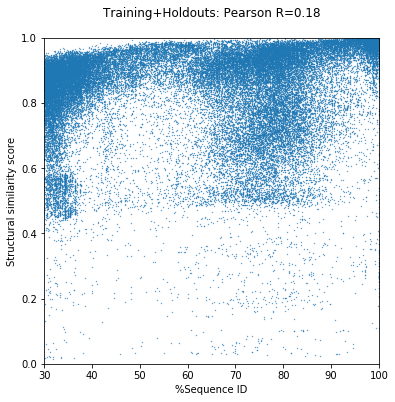

In [29]:
import scipy

df_sample = df_scores.sample(50000)
pidentity = df_sample['pidentity']
tm_score = 1 - df_sample['distance']

R, p = scipy.stats.pearsonr(pidentity, tm_score)
title = "Training+Holdouts: Pearson R={:.2f}\n".format(R)

fig = plt.figure(figsize=(6, 6))
fig.patch.set_facecolor("white")
plt.axis((30, 100, 0., 1))
plt.scatter(pidentity, tm_score, s=0.1)
#plt.plot([0, 1], [0, 1], color="red")
plt.title(title)
plt.xlabel("%Sequence ID")
plt.ylabel("Structural similarity score")
#file_name = SAVE_PLOTS_DIR + "-TEST-SINGLEHO-actual_vs_predicted.png"
#plt.savefig(file_name, format="png", pad_inches=0.3)
plt.show()

# TMscore vs RMSD

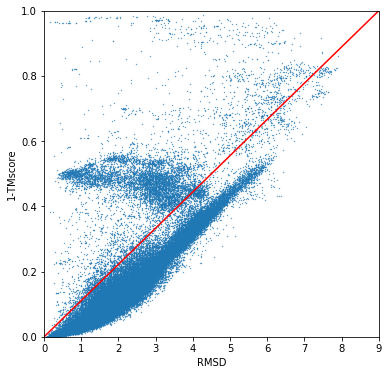

In [30]:
df_sampled = df_scores.sample(100000)
y = df_sampled.distance.values
x = df_sampled.RMSD.values

fig = plt.figure(figsize=(6, 6))
fig.patch.set_facecolor("white")
plt.axis((0.0, 9, 0.0, 1))
plt.plot([0, 9], [0, 1], color="red")
plt.scatter(x, y, s=0.1)
#plt.title(title)
plt.xlabel("RMSD")
plt.ylabel("1-TMscore")
plt.show()

<Figure size 216x216 with 0 Axes>

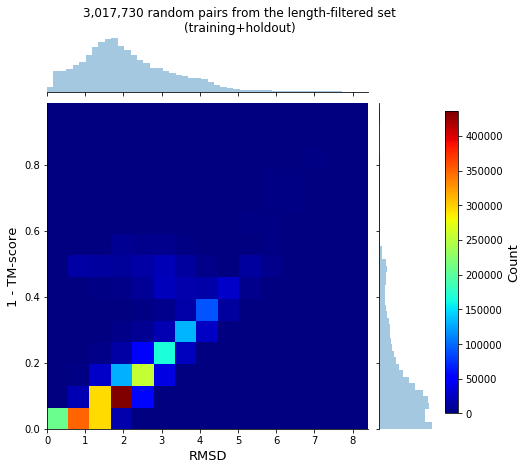

In [31]:
df_sampled = df_scores
y = df_sampled.distance.values
x = df_sampled.RMSD.values

title = "{:,} random pairs from the length-filtered set\n(training+holdout)".format(len(df_sampled))
xlabel = "RMSD"
ylabel = "1 - TM-score"
savefile = folder + prefix + "tmscore_vs_RMSD.png"

fig = plt.figure(figsize=(3,3))
fig.patch.set_facecolor('white')

ax1 = sns.jointplot(x=x, y=y)
ax1.ax_joint.cla()
plt.sca(ax1.ax_joint)

plt.title(title, y=1.2, x=0.6)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel,fontsize=13)

h = plt.hist2d(x, y, bins=(15, 15), cmap=cm.jet);
cbar_ax = ax1.fig.add_axes([1, 0.1, .03, .7])
cb = plt.colorbar(cax=cbar_ax)
cb.set_label('Count',fontsize=13)
plt.savefig(savefile)

# Inspect above-diagonal pairs

In [32]:
df_selected = df_scores[df_scores.RMSD !=0].copy()
df_selected['d_rmsd_ratio'] = [ 9*d/rmsd for d, rmsd in df_selected[['distance', 'RMSD']].values ]

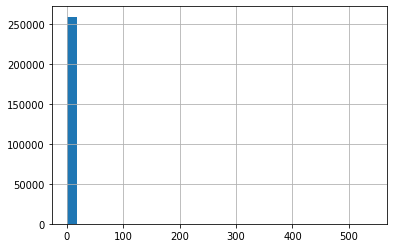

In [33]:
df_selected[df_selected['d_rmsd_ratio']>1]['d_rmsd_ratio'].hist(bins=30)

In [34]:
df_offdiagonals = df_selected[df_selected['d_rmsd_ratio']>1.0]
print("Offdiagonals count:", len(df_offdiagonals))
df_offdiagonals[['qid', 'tid', 'TM1',
       'TM2', 'RMSD', 'pID1', 'pID2', 'IDali', 'L1', 'L2', 'Lali', 'pidentity', 'aln_len',
       'mismatches', 'qlen', 'tlen', 'perc_q_cov_per_hsp', 'distance', 'd_rmsd_ratio']].sample(20).sort_values(by='pidentity')

Offdiagonals count: 259454


qid       tid     TM1     TM2  RMSD   pID1   pID2  IDali   L1  \
2830819  6mwr_C    5f6h_L  0.4707  0.4908  3.11  0.135  0.142  0.244  222   
2679424  4y83_A    6c83_A  0.5713  0.6806  2.02  0.194  0.234  0.314  299   
987315   4prh_D    1zgl_P  0.5327  0.4564  4.09  0.178  0.149  0.252  202   
449731   1icn_A    4zh6_A  0.5208  0.5138  2.68  0.183  0.180  0.296  131   
273270   1ekb_B    5o32_I  0.3254  0.3191  4.86  0.162  0.158  0.339  235   
2149361  4cdh_A    5wkz_L  0.5413  0.5278  3.30  0.155  0.151  0.234  206   
2368081  4k29_A  6sl9_AAA  0.7495  0.7578  1.76  0.280  0.283  0.351  261   
2567096  4qrp_E    4zs7_L  0.4345  0.4943  3.54  0.144  0.167  0.271  243   
3155675  6g1e_B    6rcq_B  0.5453  0.5383  3.00  0.184  0.182  0.284  206   
2518505  4ot7_A    6gi8_A  0.5434  0.4657  2.81  0.269  0.229  0.454  308   
97133    1aya_A    1fyr_A  0.5700  0.6021  2.08  0.257  0.274  0.394  101   
1409913  2wkh_A    5oe0_A  0.0222  0.0225  1.95  0.004  0.004  0.167  244   
1349597  2r5y_A    6es3_K  0.7530  0.7630  1.08  0.479  0.486  0.603   73   
3081806  5zol_A    6sbi_A  0.2449  0.2494  5.52  0.036  0.037  0.086  222   
626385   1moe_A    2hh0_H  0.4741  0.5230  1.37  0.375  0.415  0.763  240   
3188791  6mtx_H    6vtw_H  0.5084  0.5084  1.67  0.315  0.315  0.585  219   
3130776  6db7_L    6mi2_B  0.5161  0.5184  2.69  0.431  0.433  0.752  211   
2141519  4by3_A    6hff_A  0.1729  0.1729  7.30  0.147  0.147  0.473  361   
1769344  3l1n_A    3zf5_A  0.2582  0.2401  5.31  0.026  0.024  0.057  152   
2010361  3tro_A    5xki_A  0.2323  0.2673  6.12  0.020  0.024  0.053  307   

          L2  Lali  pidentity  aln_len  mismatches  qlen  tlen  \
2830819  212   123     30.374      214         131   244   216   
2679424  248   185     31.439      264         160   332   285   
987315   242   143     31.544      149          88   208   249   
449731   133    81     32.331      133          82   131   133   
273270   241   112     32.489      237         148   235   244   
2149361  212   137     34.409       93          59   255   217   
2368081  258   208     34.483      232         134   295   258   
2567096  210   129     36.098      205         110   245   216   
3155675  209   134     38.710       93          55   227   217   
2518505  362   183     40.385      364         205   381   373   
97133     95    66     40.789       76          45   101   114   
1409913  241     6     48.963      241         120   248   265   
1349597   72    58     61.404       57          22    88    72   
3081806  216    93     63.265       49          17   255   265   
626385   217   118     76.271      118          25   240   217   
3188791  219   118     76.471      221          48   225   219   
3130776  210   121     85.981      214          30   214   214   
2141519  361   112     99.746      393           1   393   393   
1769344  169    70    100.000       34           0   194   204   
2010361  253   114    100.000       35           0   354   293   

         perc_q_cov_per_hsp  distance  d_rmsd_ratio  
2830819                  86    0.5092      1.473569  
2679424                  77    0.3194      1.423069  
987315                   66    0.4673      1.028289  
449731                   98    0.4792      1.609254  
273270                   98    0.6746      1.249259  
2149361                  36    0.4587      1.251000  
2368081                  75    0.2422      1.238523  
2567096                  82    0.5057      1.285678  
3155675                  40    0.4547      1.364100  
2518505                  93    0.4566      1.462420  
97133                    75    0.3979      1.721683  
1409913                  97    0.9775      4.511538  
1349597                  65    0.2370      1.975000  
3081806                  19    0.7506      1.223804  
626385                   49    0.4770      3.133577  
3188791                  97    0.4916      2.649341  
3130776                 100    0.4816      1.611301  
2141519                 100    0.82

In [35]:
df_sampled = df_offdiagonals.sample(50000)

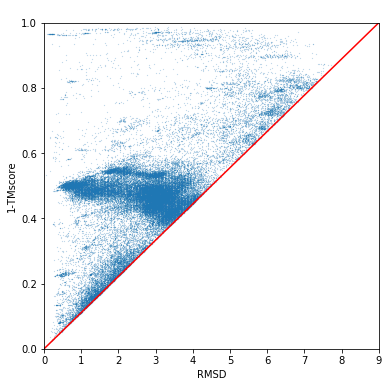

In [36]:
x = df_sampled.RMSD.values
y = df_sampled.distance.values
scatter_x_vs_y(x,y,9,1,"RMSD","1-TMscore")

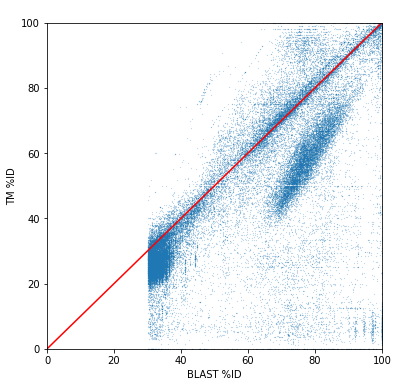

In [37]:
x = df_sampled.pidentity.values
y = 100*df_sampled.IDali.values
scatter_x_vs_y(x,y,100,100,"BLAST %ID","TM %ID")

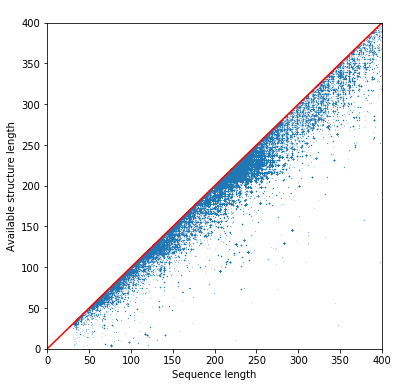

In [38]:
x = df_offdiagonals.qlen_tm.values
y = df_offdiagonals.L1.values
scatter_x_vs_y(x,y,400,400,"Sequence length","Available structure length")

In [39]:
df_offdiagonals.columns

Index(['pdbid1', 'model1', 'chain1', 'pdbid2', 'model2', 'chain2', 'TM1',
       'TM2', 'RMSD', 'pID1', 'pID2', 'IDali', 'L1', 'L2', 'Lali', 'qseq',
       'tseq', 'qlen_tm', 'tlen_tm', 'qid', 'tid', 'pidentity', 'aln_len',
       'mismatches', 'qlen', 'tlen', 'perc_q_cov_per_hsp', 'evalue',
       'bitscore', 'train_or_holdout', 'distance', 'weight', 'max_TM_pid',
       'TMoverBlastPID', 'd_rmsd_ratio'],
      dtype='object')

In [40]:
seqid=0.3
structid=.50

(structid/seqid)**3

4.629629629629631

# Find the number of connected components in the TM-score network 

In [41]:
import networkx as nx

In [42]:
def get_connected_comps(df):
    edge_list = df[['qid', 'tid', 'distance']].values.tolist()
    edge_list_for_nx = [[q, t, {'w': d}] for q, t, d in edge_list]        
    G = nx.Graph(edge_list_for_nx)
    cc = sorted(nx.connected_components(G), key=len, reverse=True)
    return cc, edge_list

## Look into all examples

In [43]:
cc, edge_list = get_connected_comps(df_scores)

In [44]:
print("#connected components:", len(cc))
print("Largest component size:", len(cc[0]))

#connected components: 6046
Largest component size: 20673


In [45]:
n_pairs_in_cc_list = [len(x) for x in cc]
cc_index = range(1, len(n_pairs_in_cc_list)+1)

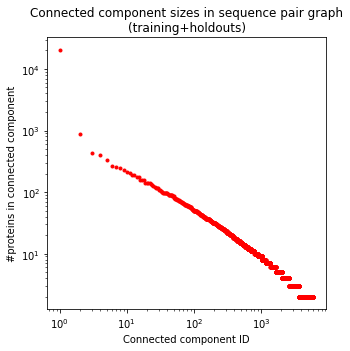

In [46]:
fig, ax = plt.subplots(figsize=(5,5))
fig.patch.set_facecolor('white')

plt.plot(cc_index, n_pairs_in_cc_list,  "r.")
plt.xscale('log')
plt.yscale('log')
#plt.axis((.5, 50000, .5, 2000))
plt.xlabel("Connected component ID")
plt.ylabel("#proteins in connected component")
plt.title("Connected component sizes in sequence pair graph\n(training+holdouts)")
plt.show()

In [47]:
df_largest_cc = df_scores[df_scores.qid.isin(cc[0])]

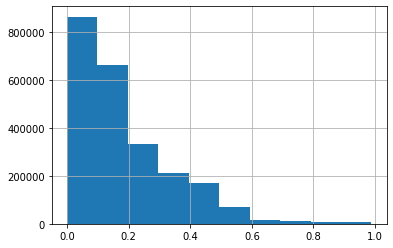

In [48]:
fig, ax = plt.subplots(figsize=(6,4))
fig.patch.set_facecolor('white')
df_largest_cc.distance.hist(ax=ax)

## Now filter out all distances < 0.5, and count the CCs

In [49]:
df_scores_pruned = df_scores[df_scores.distance<0.5]
cc, edge_list = get_connected_comps(df_scores_pruned)

In [50]:
print("#connected components:", len(cc))
print("Largest component size:", len(cc[0]))

#connected components: 6335
Largest component size: 6051


In [51]:
n_pairs_in_cc_list = [len(x) for x in cc]
cc_index = range(1, len(n_pairs_in_cc_list)+1)

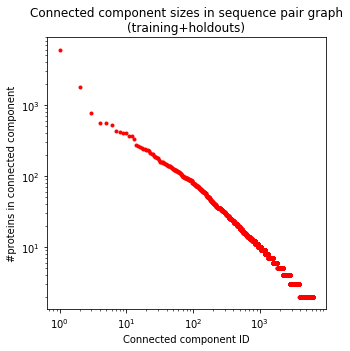

In [52]:
fig, ax = plt.subplots(figsize=(5,5))
fig.patch.set_facecolor('white')
plt.plot(cc_index, n_pairs_in_cc_list,  "r.")
plt.xscale('log')
plt.yscale('log')
#plt.axis((.5, 50000, .5, 2000))
plt.xlabel("Connected component ID")
plt.ylabel("#proteins in connected component")
plt.title("Connected component sizes in sequence pair graph\n(training+holdouts)")
plt.show()

In [53]:
df_largest_cc = df_scores[df_scores.qid.isin(cc[0])]

In [54]:
fig, ax = plt.subplots(figsize=(5,4))
fig.patch.set_facecolor('white')
df_largest_cc.distance.hist(ax=ax)
plt.xlabel("tm-score")
plt.ylabel("count")
plt.title("tm-score dist for the largest connnected component\n(training+holdouts)")
plt.show()

## Look into the largest connected component in the unpruned graph

### How many CCs does the largest one split into if you remove links w/ d<0.5?

In [55]:
df_largest_cc_pruned = df_largest_cc[df_largest_cc.distance<0.5]

In [56]:
df_largest_cc_pruned.distance.hist()

In [57]:
cc_2, edge_list_2 = get_connected_comps(df_largest_cc_pruned)

In [58]:
len(cc_2)

1

In [59]:
n_pairs_in_cc_list = [len(x) for x in cc_2]
cc_index = range(1, len(n_pairs_in_cc_list)+1)

In [60]:
fig, ax = plt.subplots(figsize=(5,5))
fig.patch.set_facecolor('white')
plt.plot(cc_index, n_pairs_in_cc_list,  "r.")
plt.xscale('log')
plt.yscale('log')
#plt.axis((.5, 50000, .5, 2000))
plt.xlabel("Connected component ID")
plt.ylabel("#proteins in connected component")
plt.title("CC sizes in the largest CC after pruning d>0.5 links")
plt.show()

In [61]:
len(cc_2[0])

6051

In [62]:
cc_index

range(1, 2)

# Does supplementing blast alignment to TMalign yield a considerable improvement in TMscores?

## Find rows with TM %id == 0. Since all blast %id >0, these rows yield blast_pid/tm_pid = inf

In [63]:
df_zero_TM_pid = df_scores[df_scores['max_TM_pid']<=0]

In [64]:
df_zero_TM_pid[['pdbid1', 'chain1', 'pdbid2', 'chain2', 'TM1',
       'TM2', 'RMSD', 'pID1', 'pID2', 'IDali', 'qid', 'tid', 'pidentity', 'aln_len',
       'mismatches', 'qlen', 'tlen', 'perc_q_cov_per_hsp',
       'bitscore']].sort_values(by='pidentity', ascending=False).head(20)

pdbid1 chain1 pdbid2 chain2     TM1     TM2  RMSD  pID1  pID2  IDali  \
3163619   6hbd      A   6hyh      A  0.0445  0.0446  5.33   0.0   0.0    0.0   
2475486   4nnu      A   4qpj      A  0.2629  0.2484  4.80   0.0   0.0    0.0   
2816618   5eid      A   5jzv      A  0.3779  0.2922  4.08   0.0   0.0    0.0   
2639696   4whv      A   6kfp      D  0.1163  0.1131  3.11   0.0   0.0    0.0   
1773744   3l7y      A   5u4z      A  0.2206  0.2879  6.32   0.0   0.0    0.0   
2931991   5lb7      A   5myd      A  0.2714  0.2790  4.60   0.0   0.0    0.0   
1739822   3jvz      X   6kfp      D  0.1131  0.1152  3.70   0.0   0.0    0.0   
2793774   5dk8      A   5j8p      B  0.0325  0.1288  1.50   0.0   0.0    0.0   
474917    1izl      E   1s5l      E  0.4652  0.3010  1.96   0.0   0.0    0.0   
2767746   5csj      C   5csn      C  0.3053  0.3340  2.00   0.0   0.0    0.0   
1462024   2yje      M   3tpm      B  0.0808  0.1722  1.05   0.0   0.0    0.0   
2767745   5csi      C   5csn      C  0.1717  0.1356  0.59   0.0   0.0    0.0   
2435676   4m03      A   4ofe      A  0.2099  0.2320  4.94   0.0   0.0    0.0   
3039023   6njd      A   5vyc     f1  0.1558  0.2588  3.69   0.0   0.0    0.0   
1313416   2q33      B   3mon      B  0.2696  0.0566  0.56   0.0   0.0    0.0   
1313415   2q33      A   4mon      A  0.6541  0.0454  0.07   0.0   0.0    0.0   
2458781   4n4g      A   4umi      A  0.2019  0.3060  4.83   0.0   0.0    0.0   
1221486   2iw5      B   3zez      A  0.2288  0.1935  4.58   0.0   0.0    0.0   
3081868   5zqi      A   6p5q      A  0.1919  0.1729  6.13   0.0   0.0    0.0   
1147645   2g0i      A   6ey2      A  0.2697  0.2815  3.79   0.0   0.0    0.0   

            qid      tid  pidentity  aln_len  mismatches  qlen  tlen  \
3163619  6hbd_A   6hyh_A      100.0      319           0   320   319   
2475486  4nnu_A   4qpj_A      100.0       36           0   230   243   
2816618  5eid_A   5jzv_A      100.0       34           0   168   206   
2639696  4whv_A   6kfp_D      100.0       76           0    83    77   
1773744  3l7y_A   5u4z_A      100.0       34           0   304   265   
2931991  5lb7_A   5myd_A      100.0       34           0   212   207   
1739822  3jvz_X   6kfp_D      100.0       76           0    81    77   
2793774  5dk8_A   5j8p_B      100.0       74           0    76    76   
474917   1izl_E   1s5l_E      100.0       83           0    83    84   
2767746  5csj_C   5csn_C      100.0       25           0    42    40   
1462024  2yje_M   3tpm_B      100.0      120           0   137   120   
2767745  5csi_C   5csn_C      100.0       32           0    49    40   
2435676  4m03_A   4ofe_A      100.0       34           0   210   192   
3039023  6njd_A  5vyc_f1      100.0       76           0   157   156   
1313416  2q33_B   3mon_B      100.0       48           0    48    50   
1313415  2q33_A   4mon_A      100.0       43           0    43    45   
2458781  4n4g_A   4umi_A      100.0       33           0   252   208   
1221486  2iw5_B   3zez_A      100.0       34           0   235   204   
3081868  5zqi_A   6p5q_A      100.0       36           0   277   308   
1147645  2g0i_A   6ey2_A      100.0       24           0   145   146   

         perc_q_cov_per_hsp  bitscore  
3163619                  99     650.0  
2475486                  16      56.2  
2816618                  20      52.0  
2639696                  92     153.0  
1773744                  11      53.1  
2931991                  16      54.3  
1739822                  94     154.0  
2793774                  97     149.0  
474917                  100     171.0  
2767746                  60      52.0  
1462024                  88     233.0  
2767745                  65      65.9  
2435676                  16      51.2  
3039023                  48     157.0  
1313416                 100     101.0  
1313415                 100      89.4  
2458781                  13      50.1  
1221486                  14      51.6  
3081868                  13      64.3  
1147645       

In [65]:
%%bash
fgrep -A1 1bi4_A nr_pdb_filtered.faa > pdb/1bi4_A.faa
fgrep -A1 6nuj_A nr_pdb_filtered.faa > pdb/6nuj_A.faa

In [66]:
df_scores[['pdbid1', 'chain1', 'pdbid2', 'chain2', 'TM1',
       'TM2', 'RMSD', 'pID1', 'pID2', 'IDali', 'qid', 'tid', 'pidentity', 'aln_len',
       'mismatches', 'qlen', 'tlen', 'perc_q_cov_per_hsp',
       'bitscore']].sort_values(by='pidentity', ascending=False).head(20)

pdbid1 chain1 pdbid2 chain2     TM1     TM2  RMSD   pID1   pID2  \
1615916   3epz      A   5ydr      B  0.7434  0.6765  3.67  0.686  0.612   
750229    1qkm      A   1u3r      A  0.9039  0.9001  1.60  0.904  0.900   
750083    1qjc      A   6cck      A  0.9706  0.9586  0.95  1.000  0.987   
1945472   3r4m      A   6ei5      A  0.9275  0.9532  1.43  0.972  1.000   
1945466   3r4m      A   5j82      A  0.9336  0.9642  1.22  0.967  1.000   
750107    1qk0      A   3cbh      A  0.9979  0.9925  0.32  1.000  0.995   
750228    1qkm      A   1u3q      A  0.9027  0.9183  1.55  0.878  0.894   
1945462   3r4m      A   5j2x      A  0.9328  0.9589  1.47  0.967  0.995   
1945461   3r4m      A   5j20      A  0.9350  0.9656  1.22  0.963  0.995   
1945456   3r4m      A   4ykq      A  0.9239  0.9541  1.56  0.967  1.000   
750079    1qjc      A   5jbn      A  0.9906  0.9722  0.50  1.000  0.981   
1945452   3r4m      A   4nh7      A  0.9263  0.9611  1.29  0.963  1.000   
1945451   3r4m      A   4lwe      A  0.9291  0.9594  1.31  0.967  1.000   
1945449   3r4m      A   4egh      A  0.9313  0.9572  1.49  0.972  1.000   
1945448   3r4m      A   4eeh      A  0.9239  0.9586  1.47  0.963  1.000   
1945447   3r4m      A   4b7p      A  0.9907  0.9953  0.38  0.995  1.000   
1945446   3r4m      A   4awo      A  0.9233  0.9675  1.26  0.949  0.995   
1945445   3r4m      A   3tuh      A  0.9435  0.9699  1.07  0.972  1.000   
750082    1qjc      A   6b7a      A  0.9744  0.9623  0.92  1.000  0.987   
750046    1qj4      A   1yb6      A  0.9998  0.9998  0.09  1.000  1.000   

         IDali     qid     tid  pidentity  aln_len  mismatches  qlen  tlen  \
1615916  0.699  3epz_A  5ydr_B      100.0      249           0   268   250   
750229   0.959  1qkm_A  1u3r_A      100.0      241           0   255   241   
750083   1.000  1qjc_A  6cck_A      100.0      158           0   158   161   
1945472  1.000  3r4m_A  6ei5_A      100.0      209           0   228   209   
1945466  1.000  3r4m_A  5j82_A      100.0      225           0   228   225   
750107   1.000  1qk0_A  3cbh_A      100.0      363           0   363   365   
750228   0.935  1qkm_A  1u3q_A      100.0      240           0   255   240   
1945462  0.995  3r4m_A  5j2x_A      100.0      208           0   228   209   
1945461  0.995  3r4m_A  5j20_A      100.0      207           0   228   208   
1945456  1.000  3r4m_A  4ykq_A      100.0      228           0   228   238   
750079   1.000  1qjc_A  5jbn_A      100.0      158           0   158   170   
1945452  1.000  3r4m_A  4nh7_A      100.0      228           0   228   233   
1945451  1.000  3r4m_A  4lwe_A      100.0      208           0   228   208   
1945449  1.000  3r4m_A  4egh_A      100.0      228           0   228   232   
1945448  1.000  3r4m_A  4eeh_A      100.0      228           0   228   229   
1945447  1.000  3r4m_A  4b7p_A      100.0      228           0   228   230   
1945446  1.000  3r4m_A  4awo_A      100.0      228           0   228   230   
1945445  1.000  3r4m_A  3tuh_A      100.0      209           0   228   209   
750082   1.000  1qjc_A  6b7a_A      100.0      158           0   158   167   
750046   1.000  1qj4_A  1yb6_A      100.0      256           0   257   256   

         perc_q_cov_per_hsp  bitscore  
1615916                  93     516.0  
750229                   95     489.0  
750083                  100     327.0  
1945472                  92     429.0  
1945466                  99     461.0  
750107                  100     743.0  
750228                   94     487.0  
1945462                  91     427.0  
1945461                  91     425.0  
1945456                 100     467.0  
750079                  100     325.0  
1945452                 100     466.0  
1945451                  91     427.0  
1945449                 100     466.0  
1945448                 100     466.0  
1945447                 100     466.0  
1945446                 100     467.0  
1945445                  92     429.0  
750082                  100     3

## Look for inconsistent blast vs tmalign %id pairs

### ...find high blast %id, lower TM IDali 

In [151]:
inconsistent_filter = (df_scores['IDali']<=.90) &\
                      (df_scores['IDali']>.0) &\
                      (df_scores['pidentity']==100) &\
                      (df_scores['Lali']/df_scores['aln_len']<0.9) &\
                      (df_scores['perc_q_cov_per_hsp']>=99) 
            
#                     (df_scores['chain1']=='A') &\
#                     (df_scores['chain2']=='A') &\
df_inconsistent = df_scores[inconsistent_filter]

In [152]:
len(df_inconsistent)

332

In [153]:
percent = 100 * len(df_inconsistent)/len(df_scores)
print(f"{percent:.2f}%")

0.01%


In [154]:
df_inconsistent[['qid','tid', 'pID1', 'pID2', 'RMSD', 'max_TM_pid', 'IDali', "Lali", 'pidentity', 'aln_len',
                 'mismatches', 'qlen', 'tlen', 'perc_q_cov_per_hsp']].sort_values(by='max_TM_pid', ascending=False).head(5)

qid     tid   pID1   pID2  RMSD  max_TM_pid  IDali  Lali  \
1841815  3nkd_A  5ds4_A  0.855  0.875  2.97        87.5  0.892   251   
1282752  2oug_A  5ond_A  0.837  0.874  0.93        87.4  0.881   134   
798464   1s3o_A  2dud_A  0.776  0.874  1.19        87.4  0.874    95   
1090968  2dud_A  6rup_A  0.874  0.748  0.92        87.4  0.874    95   
1354941  2rd0_B  4l1b_B  0.871  0.437  1.82        87.1  0.871   139   

         pidentity  aln_len  mismatches  qlen  tlen  perc_q_cov_per_hsp  
1841815      100.0      305           0   305   306                 100  
1282752      100.0      161           0   162   162                  99  
798464       100.0      132           0   132   133                 100  
1090968      100.0      133           0   133   142                 100  
1354941      100.0      279           0   279   324                 100

In [172]:
http = "https://files.rcsb.org/download/"
index = 1282752
rec = df_inconsistent.loc[index]
qid = rec['qid']
tid = rec['tid']
qseq = rec['qseq']
tseq = rec['tseq']

q_pdbid = rec['pdbid1']
t_pdbid = rec['pdbid2']
q_chain = rec['chain1']
t_chain = rec['chain2']

print(q_pdbid, t_pdbid)

! wget {http}{q_pdbid}.cif -q -N -P ./pdb 
! wget {http}{t_pdbid}.cif -q -N -P ./pdb
! wget {http}{q_pdbid}.pdb -q -N -P ./pdb
! wget {http}{t_pdbid}.pdb -q -N -P ./pdb

print(f">{qid}\n{qseq}\n")
print(f">{tid}\n{tseq}\n")

2oug 5ond
wget: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libuuid.so.1: no version information available (required by wget)
wget: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libuuid.so.1: no version information available (required by wget)
wget: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libuuid.so.1: no version information available (required by wget)
wget: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libuuid.so.1: no version information available (required by wget)
>2oug_A
MQSWYLLYCKRGQLQRAQEHLERQAVNCLAPMITLEKIVRGKRTAVSEPLFPNYLFVEFDPEVIHTTTINATRGVSHFVRFGASPAIVPSAVIHQLSVYKPKDIVDPATPYPGDKVIITEGAFEGFQAIFTEPDGEARSMLLLNLINKEIKHSVKNTEFRKL

>5ond_A
MQSWYLLYCKRGQLQRAQEHLERQAVNCLAPMITLEKIVRGKRTAVSEPLFPNYLFVEFDPEVIHTTTINATRGVSHFVRFGASPAIVPSAVIHQLSVYKPKDIVDPATPYPGDKVIITEGAFEGFQAIFTEPDGEARSMLLLNLINKEIKHSVKNTEFRKA



In [175]:
! cd pdb; ../TMalign {q_pdbid}.cif {t_pdbid}.cif -S1 {q_chain} -S2 {t_chain} -split 2 -ter 0 -outfmt 2

#PDBchain1	PDBchain2	TM1	TM2	RMSD	ID1	ID2	IDali	L1	L2	Lali
2oug.cif:1:A	5ond.cif:1:A	0.9222	0.9621	0.93	0.837	0.874	0.881	141	135	134
Total CPU time is  0.08 seconds


In [176]:
! cd pdb; ../TMalign {q_pdbid}.pdb {t_pdbid}.pdb -S1 {q_chain} -S2 {t_chain} -split 2 -ter 0 -outfmt 2

#PDBchain1	PDBchain2	TM1	TM2	RMSD	ID1	ID2	IDali	L1	L2	Lali
2oug.pdb:1:A	5ond.pdb:1:A	0.9222	0.9621	0.93	0.837	0.874	0.881	141	135	134
Total CPU time is  0.06 seconds


In [184]:
! cd pdb; ../TMalign {q_pdbid}.cif {t_pdbid}.cif -split 2 -ter 0 -outfmt 2

#PDBchain1	PDBchain2	TM1	TM2	RMSD	ID1	ID2	IDali	L1	L2	Lali
Total CPU time is  0.01 seconds


In [186]:
len(qseq)

162

### check tm/blast %id ratio

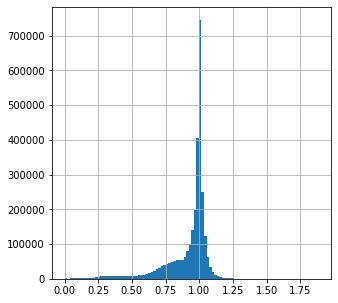

In [71]:
fig, ax = plt.subplots(figsize=(5,5))
fig.patch.set_facecolor('white')
df_scores['TMoverBlastPID'].hist(bins=100) 

### Plot perc_q_cov_per_hsp distribution

In [111]:
fig, ax = plt.subplots(figsize=(5,3))
fig.patch.set_facecolor('white')
df_scores['perc_q_cov_per_hsp'].hist(bins=100) 

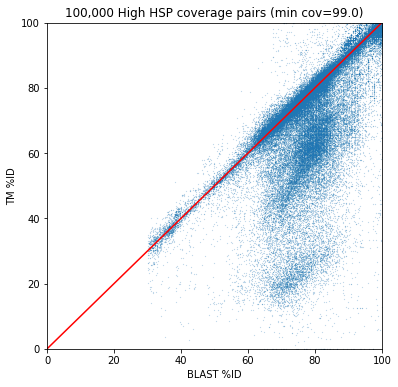

In [128]:
high_cov_threshold = 99.
high_cov_filter = df_scores['perc_q_cov_per_hsp'] > high_cov_threshold
df_high_coverage = df_scores[high_cov_filter].sample(100000)

x = df_high_coverage.pidentity.values
y = 100*df_high_coverage.IDali.values
title = "{:,} High HSP coverage pairs (min cov={:.1f})".format(len(df_high_coverage), high_cov_threshold)
scatter_x_vs_y(x,y,100,100,"BLAST %ID","TM %ID", title)

<Figure size 216x216 with 0 Axes>

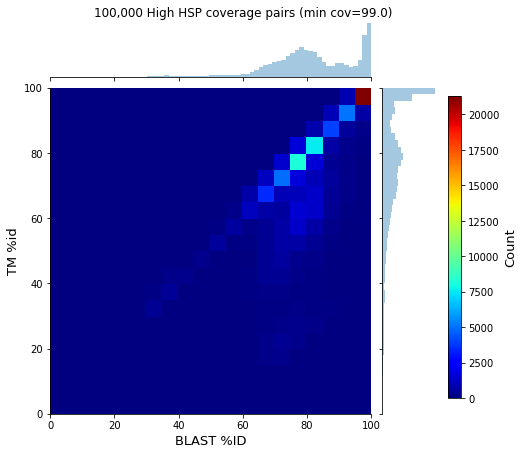

In [187]:
x = df_high_coverage.pidentity.values
y = 100*df_high_coverage.IDali.values

title = "{:,} High HSP coverage pairs (min cov={:.1f})".format(len(df_high_coverage), high_cov_threshold)
xlabel = "BLAST %ID"
ylabel = "TM %id"
savefile = folder + prefix + "high_hsp_cov_tm_vs_blast_pid.png"

fig = plt.figure(figsize=(3,3))

ax1 = sns.jointplot(x=x, y=y)
ax1.ax_joint.cla()
plt.sca(ax1.ax_joint)

plt.title(title, y=1.2, x=0.6)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel,fontsize=13)

h = plt.hist2d(x, y, bins=(20, 20), range=[[0,100],[0,100]], cmap=cm.jet);
cbar_ax = ax1.fig.add_axes([1, 0.1, .03, .7])
cb = plt.colorbar(cax=cbar_ax)
cb.set_label('Count',fontsize=13)
fig.patch.set_facecolor('white')
plt.savefig(savefile)